In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('geolocation.csv', 'geolocation'),
    ('order_items.csv', 'order_items'),
    ('orders.csv', 'orders'),
    ('payments.csv', 'payments'),
    ('products.csv', 'products'),
    ('sellers.csv', 'sellers')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='MyNewPass',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'F:/PERSONAL/E-Commerce Project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered

#  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='MyNewPass',
    database='ecommerce'
)
cur = db.cursor()



# 1. List all unique cities where customers are located.

In [42]:
query = """SELECT DISTINCT
    customer_city
FROM
    CUSTOMERS """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#  2. Count the number of orders placed in 2017.

In [9]:
query = """SELECT 
    COUNT(order_id)
FROM
    ORDERS
WHERE
    YEAR(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017", data[0][0]

('total orders placed in 2017', 45101)

#  3. Find the total sales per category.

In [37]:
query = """SELECT 
    UPPER(P.product_category) AS CATEGORY,
    ROUND(SUM(Y.payment_value), 2) AS SALES
FROM
    ORDER_ITEMS I
        JOIN
    PRODUCTS P ON I.product_id = P.product_id
        JOIN
    PAYMENTS Y ON I.ORDER_ID = Y.ORDER_ID
GROUP BY P.product_category"""

cur.execute(query)

data = cur.fetchall()

data = pd.DataFrame(data, columns= ["category","sales"])

data.head()

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67


#  4. Calculate the percentage of orders that were paid in installments.

In [13]:
query = """SELECT 
    SUM(CASE
        WHEN payment_installments >= 1 THEN 1
        ELSE 0
    END) * 100 / COUNT(*) AS EMI_PER
FROM
    PAYMENTS"""

cur.execute(query)

data = cur.fetchall()

data

[(Decimal('99.9981'),)]

#  5. Count the number of customers from each state. 

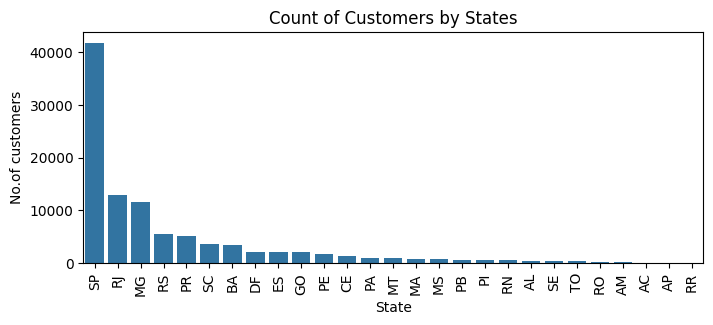

In [57]:
query = """SELECT 
    CUSTOMER_STATE, COUNT(CUSTOMER_STATE) AS NO_OF_CUSTOMERS
FROM
    CUSTOMERS
GROUP BY CUSTOMER_STATE"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["State", "No.of customers"])
df = df.sort_values(["No.of customers"], ascending= False).reset_index(drop=True)

plt.figure(figsize = (8,3))
sns.barplot(data= df , x="State", y= "No.of customers")
plt.xticks(rotation= 90)
plt.title("Count of Customers by States")
plt.show()

#   6. Calculate the number of orders per month in 2018.

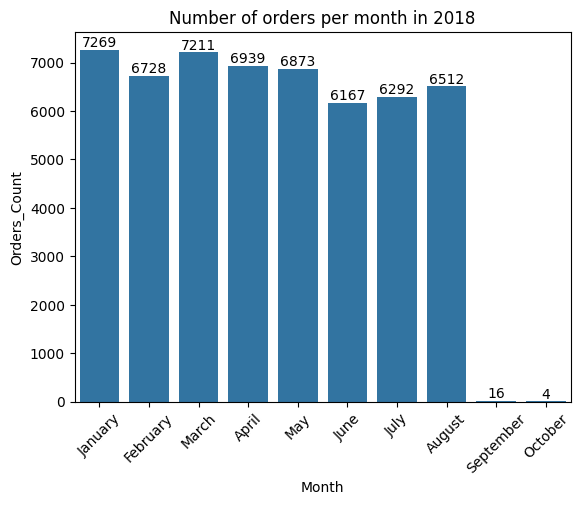

In [59]:
query = """SELECT 
    MONTHNAME(order_purchase_timestamp) AS MONTHS,
    COUNT(ORDER_ID) AS ORDERS_COUNT
FROM
    ORDERS
WHERE
    YEAR(order_purchase_timestamp) = 2018
GROUP BY MONTHNAME(order_purchase_timestamp)
ORDER BY ORDERS_COUNT DESC;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["Month","Orders_Count"])
o = ["January",	"February",	"March",	"April",	"May",	"June",	"July",	"August",	"September",	"October"]

ax = sns.barplot(data= df, x= "Month", y= "Orders_Count", order= o)
ax.bar_label(ax.containers[0])
plt.xticks(rotation= 45)
plt.title("Number of orders per month in 2018")
plt.show()

#  7. Find the average number of products per order, grouped by customer city.

In [64]:
query = """SELECT 
    A.CUSTOMER_CITY,
    ROUND(AVG(PROD_COUNT), 2) AS PROD_COUNT_PER_ORDER
FROM
    (SELECT 
        C.customer_city,
            O.order_id,
            COUNT(I.product_id) AS PROD_COUNT
    FROM
        CUSTOMERS C
    JOIN ORDERS O ON C.CUSTOMER_ID = O.CUSTOMER_ID
    JOIN ORDER_ITEMS I ON I.order_id = O.order_id
    GROUP BY C.customer_city , O.order_id) A
GROUP BY A.CUSTOMER_CITY
ORDER BY PROD_COUNT_PER_ORDER DESC
;"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["CUSTOMER_CITY", "PROD_COUNT_PER_ORDER"])
df.head()

,CUSTOMER_CITY,PROD_COUNT_PER_ORDER
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00


#  8. Calculate the percentage of total revenue contributed by each product category.

In [67]:
query = """SELECT 
    UPPER(P.product_category) AS CATEGORY,
   Round((SUM(Y.payment_value)/(SELECT sum(Y.payment_value) FROM PAYMENTS Y))*100,2) AS SALES_PER
FROM
    ORDER_ITEMS I
        JOIN
    PRODUCTS P ON I.product_id = P.product_id
        JOIN
    PAYMENTS Y ON I.ORDER_ID = Y.ORDER_ID
GROUP BY P.product_category
ORDER BY SALES_PER DESC;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["CATEGORY","SALES_PER"])
df.head()

,CATEGORY,SALES_PER
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# 9. Identify the correlation between product price and the number of times a product has been purchased.

correlation between product price and the number of times a product has been purchased is -0.04421869277068836


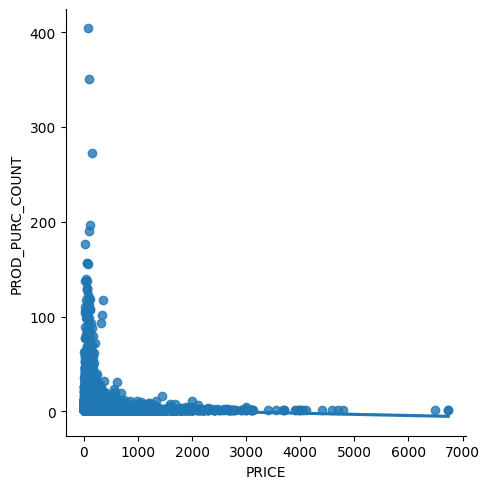

In [85]:
query = """select distinct product_id, price, count(product_id) as product_count
from order_items
group by product_id, price
order by product_count desc;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["PRODUCT_ID","PRICE","PROD_PURC_COUNT"])
corr = df["PRICE"].corr(df["PROD_PURC_COUNT"])
print("correlation between product price and the number of times a product has been purchased is",corr)
sns.lmplot(data= df, x="PRICE", y= "PROD_PURC_COUNT", ci= None)
plt.show()

#  10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [87]:
query = """select a.*, rank() over(order by revenue desc) rnk
from (select seller_id, round(sum(payment_value),2) as revenue
from order_items I
join payments P on I.order_id = P.order_id
group by seller_id
order by revenue desc) a
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["SELLER_ID","REVENUE","RANK"])
df.head()

,SELLER_ID,REVENUE,RANK
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


#  11.Calculate the moving average of order values for each customer over their order history.

In [3]:
query = """SELECT a.customer_id, a.order_purchase_timestamp,
round(avg(a.payment_value) over(partition by a.customer_id order by a.order_purchase_timestamp
rows between 2 preceding and current row),2) as mov_avg
from (SELECT O.customer_id, O.order_purchase_timestamp, P.payment_value
FROM ORDERS O
JOIN PAYMENTS P
ON O.ORDER_ID = P.ORDER_ID) a
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["customer_id","order_purchase_timestamp","mov_avg"])
df.head()

,customer_id,order_purchase_timestamp,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01


#  12.Calculate the cumulative sales per month for each year.

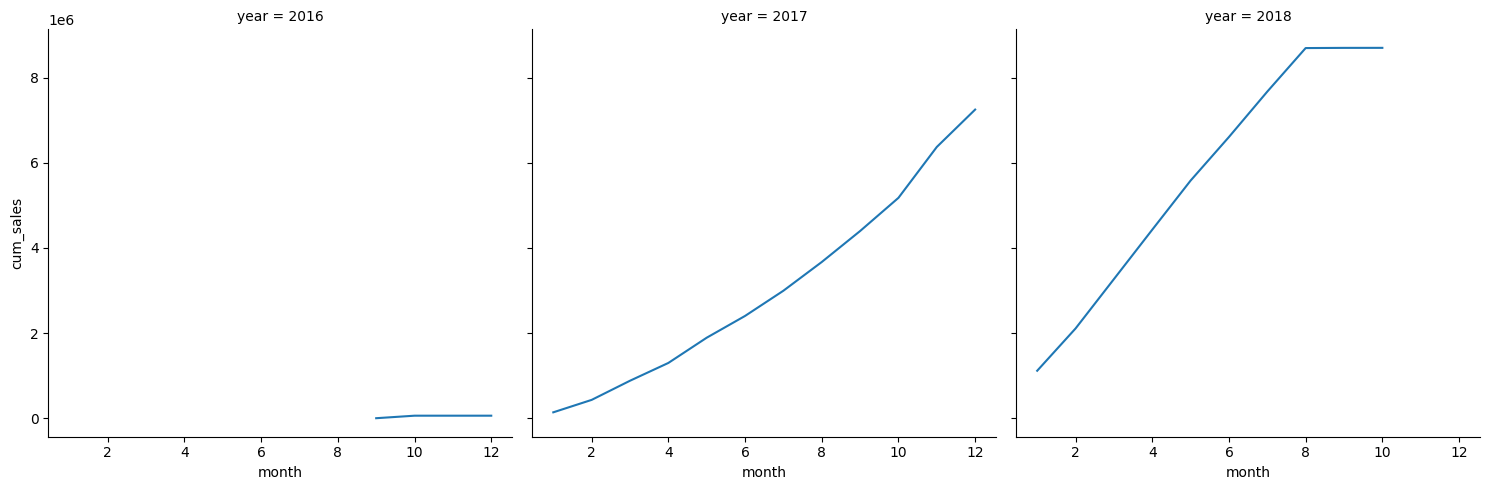

In [8]:
query = """SELECT A.*, ROUND(SUM(A.SALES) OVER(partition by A.YY order by A.MM),2) CUM_SALES
FROM (SELECT YEAR(O.order_purchase_timestamp) AS YY , MONTH(O.order_purchase_timestamp) AS MM , ROUND(SUM(P.payment_value),2) AS SALES
FROM ORDERS O
JOIN PAYMENTS P ON O.ORDER_ID = P.ORDER_ID
GROUP BY YEAR(O.order_purchase_timestamp), MONTH(O.order_purchase_timestamp)
ORDER BY YEAR(O.order_purchase_timestamp), MONTH(O.order_purchase_timestamp)) A;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["year","month","sales","cum_sales"])

sns.relplot(data= df, x= "month", y="cum_sales", kind= "line", col = "year")
plt.show()

#  13. Calculate the year-over-year growth rate of total sales.

   year       sales  pre_yy_sales  growth_rate
0  2016    59362.34           NaN          NaN
1  2017  7249746.73      59362.34      12112.7
2  2018  8699763.05    7249746.73         20.0


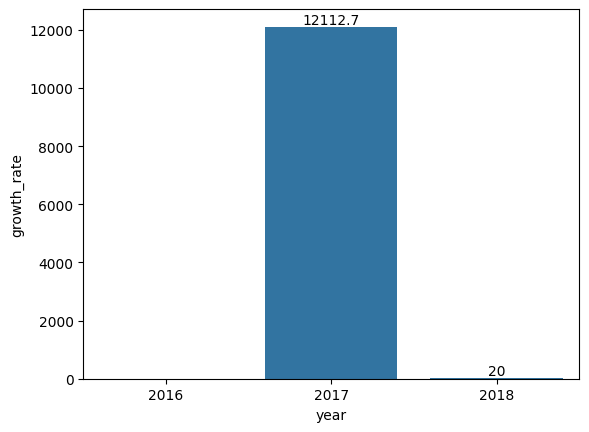

In [17]:
query = """SELECT B.*, ROUND((SALES-PRE_YY)*100/PRE_YY,2) AS GROWTH_RATE
FROM (SELECT A.*, lag(sales,1) over(order by YY) as PRE_YY
FROM (SELECT YEAR(O.order_purchase_timestamp) AS YY , ROUND(SUM(P.payment_value),2) AS SALES
FROM ORDERS O
JOIN PAYMENTS P ON O.ORDER_ID = P.ORDER_ID
GROUP BY YEAR(O.order_purchase_timestamp)
ORDER BY YEAR(O.order_purchase_timestamp)) A) B;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["year","sales","pre_yy_sales","growth_rate"])
print(df)
ax = sns.barplot(data= df, x= "year", y="growth_rate")
ax.bar_label(ax.containers[0])
plt.show()

#  14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [20]:
query = """WITH A AS (SELECT 
    C.CUSTOMER_ID,
    MIN(O.ORDER_PURCHASE_TIMESTAMP) AS FIRST_ORDER
FROM
    ORDERS O
        JOIN
    CUSTOMERS C ON O.CUSTOMER_ID = C.CUSTOMER_ID
GROUP BY C.CUSTOMER_ID),

B AS (SELECT 
    A.CUSTOMER_ID, COUNT(DISTINCT O.ORDER_PURCHASE_TIMESTAMP)
FROM
    A
        JOIN
    ORDERS O ON O.CUSTOMER_ID = A.CUSTOMER_ID
    AND O.ORDER_PURCHASE_TIMESTAMP > A.FIRST_ORDER
    AND O.ORDER_PURCHASE_TIMESTAMP < date_add(FIRST_ORDER, interval 6 MONTH)
    GROUP BY A.CUSTOMER_ID)
    
    SELECT COUNT(DISTINCT A.CUSTOMER_ID)*100/COUNT(DISTINCT B.CUSTOMER_iD) AS RETENTION_PER
    FROM A LEFT JOIN B
    ON A.CUSTOMER_ID = B.CUSTOMER_ID;
"""

cur.execute(query)

data = cur.fetchall()

print(data)

[(None,)]


#  15. Identify the top 3 customers who spent the most money in each year.

In [4]:
query = """SELECT B.*
FROM (SELECT A.YR, A.CUSTOMER_ID, A.MONEY_SPENT, RANK() OVER(partition by A.YR ORDER BY MONEY_SPENT DESC) RNK
FROM (SELECT  YEAR(O.order_purchase_timestamp) AS YR, O.CUSTOMER_ID, SUM(P.PAYMENT_VALUE) AS MONEY_SPENT 
FROM PAYMENTS P
JOIN ORDERS O ON O.ORDER_ID= P.ORDER_ID
GROUP BY YEAR(O.order_purchase_timestamp), O.CUSTOMER_ID
ORDER BY YR ASC, MONEY_SPENT DESC) A) B
WHERE RNK <= 3;
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns= ["Year", "Customer_ID", "Money_Spent","Rank"])
print(df)

   Year                       Customer_ID   Money_Spent  Rank
0  2016  a9dc96b027d1252bbac0a9b72d837fc6   1423.550049     1
1  2016  1d34ed25963d5aae4cf3d7f3a4cda173   1400.739990     2
2  2016  4a06381959b6670756de02e07b83815f   1227.780029     3
3  2017  1617b1357756262bfa56ab541c47bc16  13664.080078     1
4  2017  c6e2731c5b391845f6800c97401a43a9   6929.310059     2
5  2017  3fd6777bbce08a352fddd04e4a7cc8f6   6726.660156     3
6  2018  ec5b2ba62e574342386871631fafd3fc   7274.879883     1
7  2018  f48d464a0baaea338cb25f816991ab1f   6922.209961     2
8  2018  e0a2412720e9ea4f26c1ac985f6a7358   4809.439941     3
